In [3]:
!pip install jupyter
!pip install pandas matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install transformers dataset numpy
!pip install torch torchvision \ --index-url https://download.pytorch.org/whl/cu126



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
  Using cached pandas-2.3.3-cp310-cp310-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.8 MB)
  Using cached matplotlib-3.10.7-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.7 MB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl (509 kB)
  Using cached fonttools-4.60.1-cp310-cp310-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (4.8 MB)
  Using cached kiwisolver-1.4.9-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached contourpy-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (325 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)
  Using cached pillow-12.0.0-cp310-cp310-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (7.0 MB)
ERROR: Could not install packages due to an OSError: [Errno 13] Perm

In [4]:
!pip install --upgrade pip

  Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/ztank/sw/hprc/sw/code-ai-envs/3_10_8_llama/bin/pip'
Check the permissions.


[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, roc_auc_score, precision_score, recall_score
import torch
from transformers import (
    DistilBertTokenizer, DistilBertForSequenceClassification,
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback
)
from datasets import Dataset
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [4]:
print("Dataset Information:")
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nClass distribution in training data:")
print(train_df['target'].value_counts())

Dataset Information:
Training samples: 7613
Test samples: 3263

Class distribution in training data:
0    4342
1    3271
Name: target, dtype: int64


In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    train_df['cleaned_text'], 
    train_df['target'], 
    test_size=0.2, 
    random_state=42,
    stratify=train_df['target']
)

In [8]:
print(f"\nData split:")
print(f"Training: {len(X_train)}, Validation: {len(X_val)}")


Data split:
Training: 6090, Validation: 1523


In [9]:
print("BASELINE MODEL: TF-IDF + Logistic Regression")

BASELINE MODEL: TF-IDF + Logistic Regression


In [11]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [12]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [13]:
y_pred_baseline = baseline_model.predict(X_val_tfidf)
y_pred_proba_baseline = baseline_model.predict_proba(X_val_tfidf)[:, 1]

In [14]:
baseline_metrics = {
    'accuracy': accuracy_score(y_val, y_pred_baseline),
    'precision': precision_score(y_val, y_pred_baseline),
    'recall': recall_score(y_val, y_pred_baseline),
    'f1': f1_score(y_val, y_pred_baseline),
    'roc_auc': roc_auc_score(y_val, y_pred_proba_baseline)
}

In [15]:
print("\nBaseline Metrics:")
for metric, value in baseline_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


Baseline Metrics:
Accuracy: 0.8162
Precision: 0.8375
Recall: 0.7095
F1: 0.7682
Roc_auc: 0.8659


In [16]:
print("TRANSFORMER MODEL EXPERIMENTS")

TRANSFORMER MODEL EXPERIMENTS


In [17]:
train_dataset = Dataset.from_dict({
    'text': X_train.tolist(),
    'label': y_train.tolist()
})

val_dataset = Dataset.from_dict({
    'text': X_val.tolist(),
    'label': y_val.tolist()
})


In [18]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [19]:
print("DistilBERT  with different hyperparameters")

DistilBERT  with different hyperparameters


In [20]:
print("DistilBERT Hyperparameters Tuning:")

DistilBERT Hyperparameters Tuning:


In [21]:
distilbert_experiments = [
    {'lr': 2e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.01},
    {'lr': 3e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.01},
    {'lr': 5e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.01},
    {'lr': 2e-5, 'batch_size': 32, 'epochs': 3, 'weight_decay': 0.01},
]

In [22]:
distilbert_results=[]

In [23]:
for idx, config in enumerate(distilbert_experiments):
    print(f"\n--- Configuration {idx+1}: LR={config['lr']}, Batch={config['batch_size']}, Epochs={config['epochs']} ---")

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

    def tokenize_function(examples):
        return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

    tokenized_train = train_dataset.map(tokenize_function, batched=True)
    tokenized_val = val_dataset.map(tokenize_function, batched=True)

    training_args = TrainingArguments(
        output_dir=f'./results_distilbert_{idx+1}',
        num_train_epochs=config['epochs'],
        per_device_train_batch_size=config['batch_size'],
        per_device_eval_batch_size=32,
        warmup_steps=500,
        weight_decay=config['weight_decay'],
        learning_rate=config['lr'],
        logging_dir=f'./logs_distilbert_{idx+1}',
        logging_steps=100,
        eval_strategy='epoch',
        save_strategy='epoch',
        load_best_model_at_end=True,
        seed=42
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    trainer.train()

    # Evaluate
    eval_results = trainer.evaluate()
    distilbert_results.append({
        'config': config,
        'metrics': eval_results
    })

    print(f"Results: Accuracy={eval_results['eval_accuracy']:.4f}, F1={eval_results['eval_f1']:.4f}")


--- Configuration 1: LR=2e-05, Batch=16, Epochs=3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.674100,0.418562,0.822718,0.846570,0.717125,0.776490
2,0.421200,0.384076,0.839133,0.885122,0.718654,0.793249
3,0.338500,0.386213,0.841760,0.839080,0.781346,0.809184


Results: Accuracy=0.8391, F1=0.7932

--- Configuration 2: LR=3e-05, Batch=16, Epochs=3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.653700,0.402325,0.826658,0.820724,0.762997,0.790808
2,0.410600,0.381143,0.842416,0.855670,0.761468,0.805825
3,0.319500,0.381858,0.850295,0.861017,0.776758,0.816720


Results: Accuracy=0.8424, F1=0.8058

--- Configuration 3: LR=5e-05, Batch=16, Epochs=3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.624800,0.393123,0.837820,0.842017,0.766055,0.802242
2,0.387300,0.405289,0.824032,0.790663,0.802752,0.796662
3,0.298100,0.397741,0.841103,0.836601,0.782875,0.808847


Results: Accuracy=0.8378, F1=0.8022

--- Configuration 4: LR=2e-05, Batch=32, Epochs=3 ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.578422,0.780696,0.831950,0.613150,0.705986
2,0.657500,0.401281,0.828628,0.802773,0.796636,0.799693
3,0.462300,0.381341,0.844386,0.834671,0.795107,0.814409


Results: Accuracy=0.8444, F1=0.8144


In [40]:
print("EXPERIMENT 2: Comparing Different Transformer Architectures")

EXPERIMENT 2: Comparing Different Transformer Architectures


In [41]:
architecture_results = {}

In [42]:
best_config = {'lr': 2e-5, 'batch_size': 16, 'epochs': 3, 'weight_decay': 0.01}

In [43]:
print("Training BERT-base-uncased")

Training BERT-base-uncased


In [44]:
bert_tokenizer = Berbert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [45]:
def tokenize_bert(examples):
    return bert_tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)

In [46]:
tokenized_train_bert = train_dataset.map(tokenize_bert, batched=True)
tokenized_val_bert = val_dataset.map(tokenize_bert, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [47]:
bert_training_args = TrainingArguments(
    output_dir='./results_bert',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    warmup_steps=500,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs_bert',
    logging_steps=100,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    seed=42
)

In [48]:
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=tokenized_train_bert,
    eval_dataset=tokenized_val_bert,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [49]:
bert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.666900,0.444837,0.815496,0.884536,0.655963,0.753292
2,0.449900,0.401169,0.840446,0.811836,0.818043,0.814928
3,0.351000,0.377366,0.850952,0.858824,0.781346,0.818255


TrainOutput(global_step=573, training_loss=0.4638334976648993, metrics={'train_runtime': 125.5364, 'train_samples_per_second': 145.535, 'train_steps_per_second': 4.564, 'total_flos': 1201759745356800.0, 'train_loss': 0.4638334976648993, 'epoch': 3.0})

In [50]:
bert_results = bert_trainer.evaluate()

In [51]:
architecture_results['BERT'] = bert_results

In [52]:
print(f"BERT Results: Accuracy={bert_results['eval_accuracy']:.4f}, F1={bert_results['eval_f1']:.4f}")

BERT Results: Accuracy=0.8510, F1=0.8183


In [53]:
print("Final Evaluation: Model Comparison")

Final Evaluation: Model Comparison


In [55]:
print(all_results['Baseline (TF-IDF + LR)'].keys())

dict_keys(['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])


In [57]:
all_results = {
    'Baseline (TF-IDF + LR)': baseline_metrics,
    'DistilBERT (Best)': distilbert_results[0]['metrics'],  # Assuming first is best
    'BERT': architecture_results['BERT']
}

In [58]:
comparison_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [
        all_results['Baseline (TF-IDF + LR)']['accuracy'],
        all_results['DistilBERT (Best)']['eval_accuracy'],
        all_results['BERT']['eval_accuracy']
    ],
    'Precision': [
        all_results['Baseline (TF-IDF + LR)']['precision'],
        all_results['DistilBERT (Best)']['eval_precision'],
        all_results['BERT']['eval_precision']
    ],
    'Recall': [
        all_results['Baseline (TF-IDF + LR)']['recall'],
        all_results['DistilBERT (Best)']['eval_recall'],
        all_results['BERT']['eval_recall']
    ],
    'F1 Score': [
        all_results['Baseline (TF-IDF + LR)']['f1'],
        all_results['DistilBERT (Best)']['eval_f1'],
        all_results['BERT']['eval_f1']
    ]
})

In [59]:
print("\nModel Performance Comparison:")
print(comparison_df.to_string(index=False))


Model Performance Comparison:
                 Model  Accuracy  Precision   Recall  F1 Score
Baseline (TF-IDF + LR)  0.816152   0.837545 0.709480  0.768212
     DistilBERT (Best)  0.839133   0.885122 0.718654  0.793249
                  BERT  0.850952   0.858824 0.781346  0.818255


In [61]:
comparison_df.to_csv('model_comparison_results.csv', index=False)
comparison_df.head()


,Model,Accuracy,Precision,Recall,F1 Score
0,Baseline (TF-IDF + LR),0.816152,0.837545,0.709480,0.768212
1,DistilBERT (Best),0.839133,0.885122,0.718654,0.793249
2,BERT,0.850952,0.858824,0.781346,0.818255


In [62]:
print("\nResults saved to 'model_comparison_results.csv'")


Results saved to 'model_comparison_results.csv'


In [63]:
print("visualization")

visualization



Visualization saved to 'model_comparison_visualization.png'


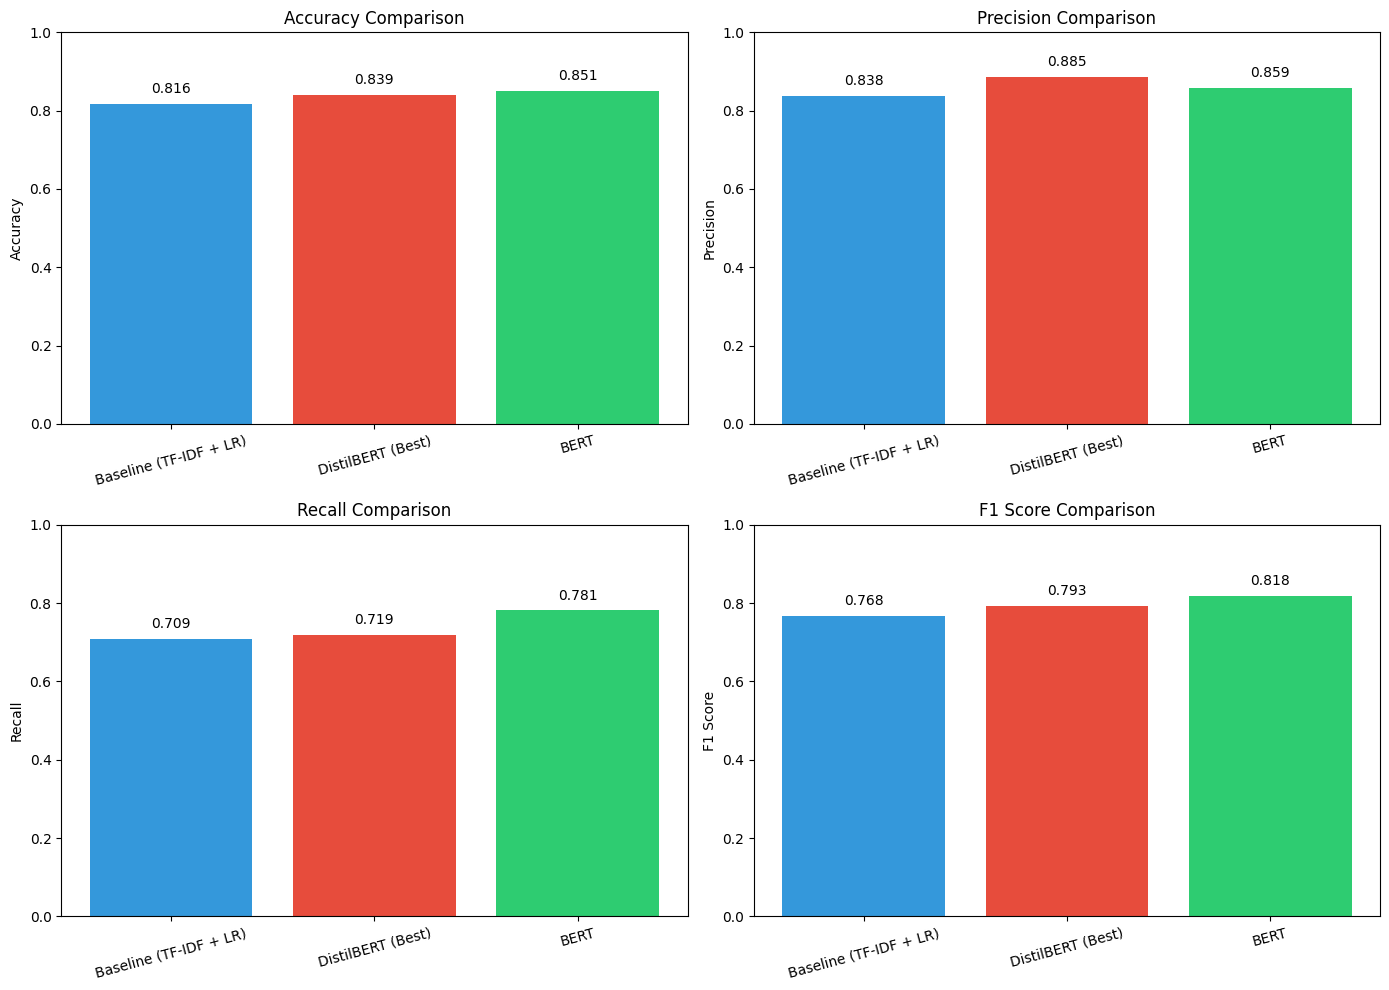

In [68]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(comparison_df['Model'], comparison_df[metric], color=['#3498db', '#e74c3c', '#2ecc71'])
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim([0, 1])
    ax.tick_params(axis='x', rotation=15)

    # Add value labels on bars
    for i, v in enumerate(comparison_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')
plt.tight_layout()
plt.savefig('model_comparison_visualization.png', dpi=300, bbox_inches='tight')
print("\nVisualization saved to 'model_comparison_visualization.png'")
plt.show()


In [69]:
print("Summary")

Summary


In [70]:
print("Completed Experiments:")

Completed Experiments:


In [71]:
print("Hyperparameter tuning for DistilBERT (learning rate, batch size)")

Hyperparameter tuning for DistilBERT (learning rate, batch size)


In [72]:
print("Architecture comparison (DistilBERT vs BERT)")

Architecture comparison (DistilBERT vs BERT)


In [73]:
print("Comprehensive evaluation metrics (Accuracy, Precision, Recall, F1, ROC-AUC)")

Comprehensive evaluation metrics (Accuracy, Precision, Recall, F1, ROC-AUC)


In [74]:
print("Baseline comparison with traditional ML")

Baseline comparison with traditional ML
